In [50]:
import json
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, KFold

warnings.simplefilter('ignore')

%matplotlib inline

# Load data

In [25]:
all_data = pd.read_csv('./dataset/csv/detail_text_with_sup.csv') 

In [26]:
train_data, test_data = train_test_split(all_data, test_size=0.2)

In [27]:
train_x, train_y = train_data.drop('is_evaluated', axis=1), train_data['is_evaluated']
test_x, test_y = test_data.drop('is_evaluated', axis=1), test_data['is_evaluated']

# Prediction using all data

Accuracy: 
0.7258579412597956
F1 Score: 
0.7710481595749946
Confusion matrix: 
[[26619 14565]
 [13189 46734]]


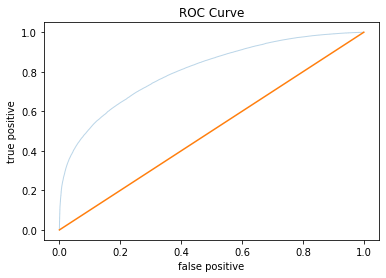

In [28]:
scores_accuracy = []

kf = KFold(n_splits=4, shuffle=True)
for tr_idx, va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    model = lgb.LGBMClassifier()
    model.fit(tr_x, np.array(tr_y).reshape(-1))
    
    va_prob = model.predict_proba(va_x)[:, 1]
    va_pred = va_prob > 0.5
    accuracy = accuracy_score(va_y, va_pred)
    f1 = f1_score(va_y, va_pred)
    cm = confusion_matrix(va_y, va_pred)
    fpr, tpr, thresholds = roc_curve(va_y, va_prob)
    
    scores_accuracy.append(accuracy)

print('Accuracy: ')
print(np.mean(scores_accuracy))
print('F1 Score: ')
print(f1)
print('Confusion matrix: ')
print(cm)
plt.plot(fpr, tpr, lw=1, alpha=0.3)
plt.plot([0, 1],[0, 1])
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title('ROC Curve')
plt.show()

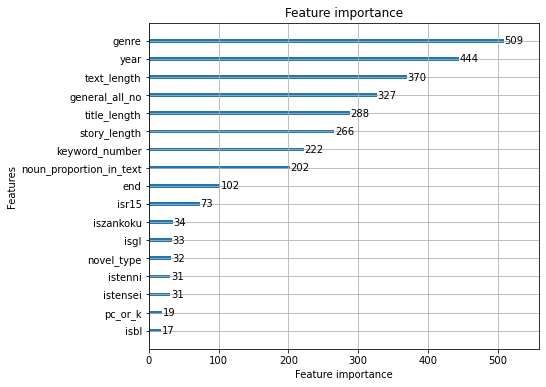

In [29]:
lgb.plot_importance(model, figsize=(7, 6))
plt.show()

yearが大きく影響しているのは、小説の需要と共有が年代によって異なるため。
(2006年は約4割の作品しか評価が付かなかったのに対して、近年は約6割の作品に評価が付いている。)

ただyearを特徴量として使用すると最近の作品ばかりレコメンドされるようになるため、使用するデータを2018年と2019年に限定して予測を行う。
(モデルの訓練に使用するデータ数を可能な限り少なくしたいという意図もある。)

またgenreを特徴量として含めると特定のジャンル(VRゲームやハイファンタジー)に偏ってレコメンドされるので除く。

# Prediction using restricted data

In [64]:
data = all_data.drop('genre', axis=1)

In [65]:
data = data[(data.year == 2018) | (data.year == 2019) | (data.year == 2020)]

In [66]:
data = data.drop('year', axis=1)

In [67]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [68]:
train_x, train_y = train_data.drop('is_evaluated', axis=1), train_data['is_evaluated']
test_x, test_y = test_data.drop('is_evaluated', axis=1), test_data['is_evaluated']

Accuracy: 
0.7147190084831616
F1 Score: 
0.7644816935498436
Confusion matrix: 
[[11627  6933]
 [ 6106 21162]]


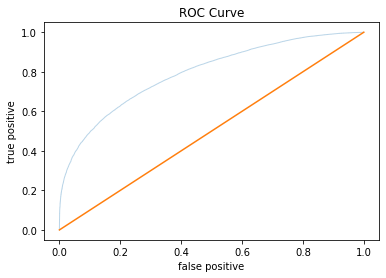

In [69]:
scores_accuracy = []

kf = KFold(n_splits=4, shuffle=True)
for tr_idx, va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    model = lgb.LGBMClassifier()
    model.fit(tr_x, np.array(tr_y).reshape(-1))
    
    va_prob = model.predict_proba(va_x)[:, 1]
    va_pred = va_prob > 0.5
    accuracy = accuracy_score(va_y, va_pred)
    f1 = f1_score(va_y, va_pred)
    cm = confusion_matrix(va_y, va_pred)
    fpr, tpr, thresholds = roc_curve(va_y, va_prob)
    
    scores_accuracy.append(accuracy)

print('Accuracy: ')
print(np.mean(scores_accuracy))
print('F1 Score: ')
print(f1)
print('Confusion matrix: ')
print(cm)
plt.plot(fpr, tpr, lw=1, alpha=0.3)
plt.plot([0, 1],[0, 1])
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title('ROC Curve')
plt.show()

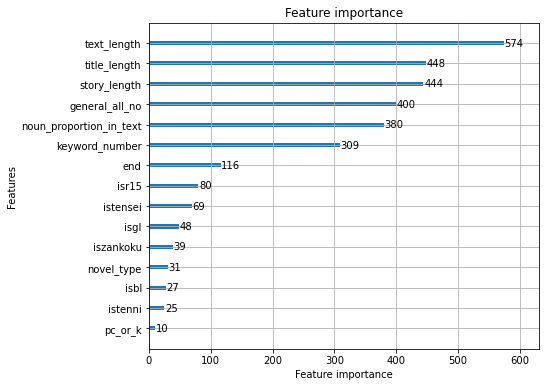

In [70]:
lgb.plot_importance(model, figsize=(7, 6))
plt.show()

# Save model

In [71]:
model = lgb.LGBMClassifier()
model.fit(train_x, np.array(train_y).reshape(-1))

LGBMClassifier()

In [72]:
pickle.dump(model, open('lightgbm_model.pkl', 'wb'))

In [73]:
model = pickle.load(open('lightgbm_model.pkl', 'rb'))

In [81]:
with open('feature_names.json', 'w') as f:
    json.dump(list(train_data.drop('is_evaluated', axis=1).columns), f)